# Basic response prediction example
In this example, the curved floating bridge created in the model creation examples is exposed to wind and wave excitation.

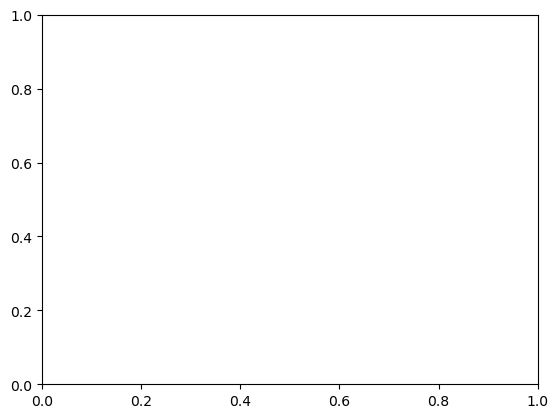

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from wawi.model import Model, Windstate, Seastate
from wawi.modal import maxreal

In [3]:
# Import model
model = Model.from_wwi('./input/model_curved.wwi')
model.n_modes = 50      # define number of dry modes

# Define omega for FRF of system and aerodynamics
omega = np.arange(0.001, 2, 0.0005)
omega_aero = np.arange(0.001, 2, 0.02)

In [4]:
# Define Windstate either from direct initiation of object
U0 = 20.0
direction = 90.0
windstate = Windstate(U0, direction, Iu=0.136, Iw=0.072, Au=6.8, Aw=9.4, Cuy=10.0, Cwy=6.5, Lux=115, Lwx=9.58)
# or from json
windstate = Windstate.from_json('./input/windstate_example.json')

# Apply windstate to model
model.assign_windstate(windstate)

In [5]:
# Define Seastate  (JONSWAP 1d wave spectrum and cos2s distribution) either from direct initiation of object
Hs=2.1
Tp=8.3
gamma=8
s=12
theta0=90.0
seastate = Seastate(Tp, Hs, gamma, theta0, s)

# or from json
seastate = Seastate.from_json('./input/seastate_example.json')

# Apply seastate to model
model.assign_seastate(seastate)

In [6]:
# Plot model
model.plot(tmat_on=['undeformed'], node_labels=True)

Widget(value='<iframe src="http://localhost:61444/index.html?ui=P_0x1ba757fcc50_0&reconnect=auto" class="pyvis…

## Modal analysis

In [8]:
model.aero.prepare_aero_matrices(omega=omega_aero, aero_sections=['girder']) # optional prep step
model.run_eig(include=['hydro', 'aero'])

[ >>>>>>>>>>>>>>>>>>>> ] 101% finished with iterative modal analysis. 


In [9]:
mode_ix = 0
model.plot_mode(mode_ix, use_dry=False, plot_wave_direction=False)
print(f'T1 = {model.results.Tn[mode_ix]:.1f} s')
print(f'xi_1 = {model.results.xi[mode_ix]*100:.1f}%')

Widget(value='<iframe src="http://localhost:61444/index.html?ui=P_0x1ba791bd610_1&reconnect=auto" class="pyvis…

T1 = 43.4 s
xi_1 = 1.0%


## Response prediction

In [ ]:
model.precompute_windaction(omega_aero, print_progress=False, aero_sections=['girder'], merge_sections=False)
model.run_freqsim(omega)
resp_wawi = model.get_result_expmax(3600, key='girder_forces')

[ ===                  ]  16% ESTABLISHING WAVE EXCITATION     

## Plot expected maximum

In [ ]:
legend_ax = []
comps = {'$M_z$ [MNm]':5}
arclength_girder_force = model.modal_dry.phi_x['girder_forces'][:, 0]

fig,ax = plt.subplots(nrows=len(comps), sharex=True, figsize=[12,7])
if np.ndim(ax)==0:
    ax = [ax]

for ix, comp in enumerate(comps):
    comp_ix = comps[comp]
    ax[ix].set_ylabel(comp)
    ax[ix].plot(arclength_girder_force,resp_wawi[comp_ix::6]/1e6, color='black', linestyle='--', alpha=0.5, label='Multimodal')
    ax[ix].set_ylim(bottom=0)
    
ax[-1].set_xlabel('x [m]')
# ax[-1].set_xlim(left=0)
ax[0].legend(frameon=False, loc='upper center', ncol=2)